In [239]:
import os
import re
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [240]:
df = pd.read_csv("titanic.csv")
df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1, inplace=True)

target = 'Survived'
labels = ['Not-Survived','Survived']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S



Inference: The Datset consists of 8 features & 891 samples.


In [241]:
df.nunique().sort_values()

Survived      2
Sex           2
Pclass        3
Embarked      3
SibSp         7
Parch         7
Age          88
Fare        248
dtype: int64

In [242]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=15:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 2 numerical & 5 categorical features.


In [243]:
display(df.describe())

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


            Target Variable Distribution           


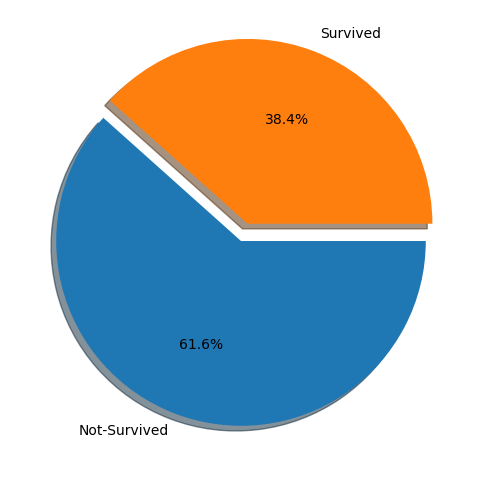

In [244]:
MAP={}
for e, i in enumerate(df[target].unique()):
    MAP[i]=labels[e]
#MAP={0:'Not-Survived',1:'Survived'}
df1 = df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

                                     Features Distribution                                      


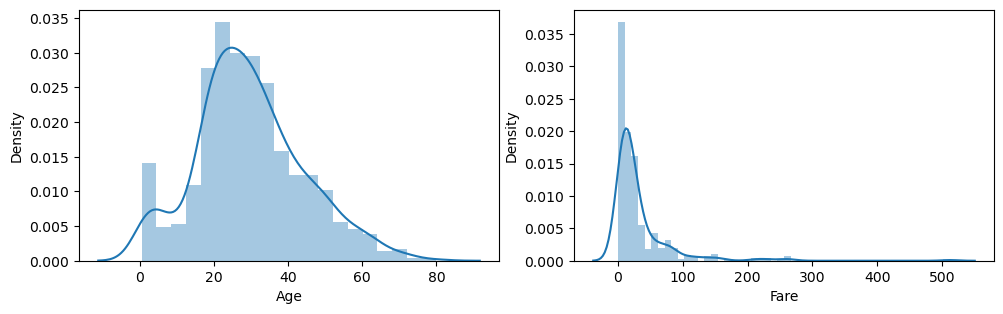

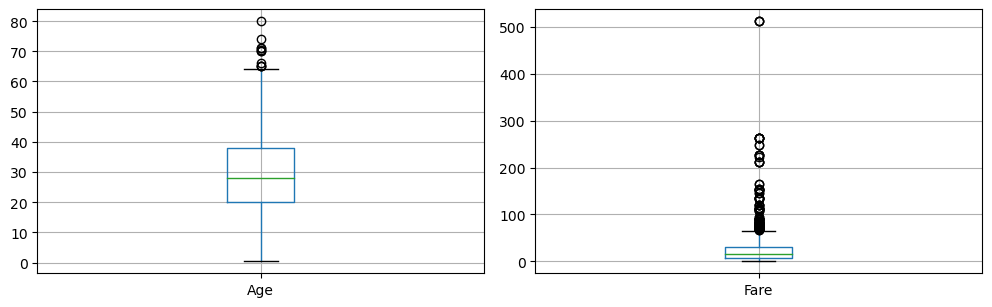

In [245]:
print('\033[1mFeatures Distribution'.center(100))

nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    sns.distplot(df[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    df.boxplot(nf[c])
plt.tight_layout()
plt.show()

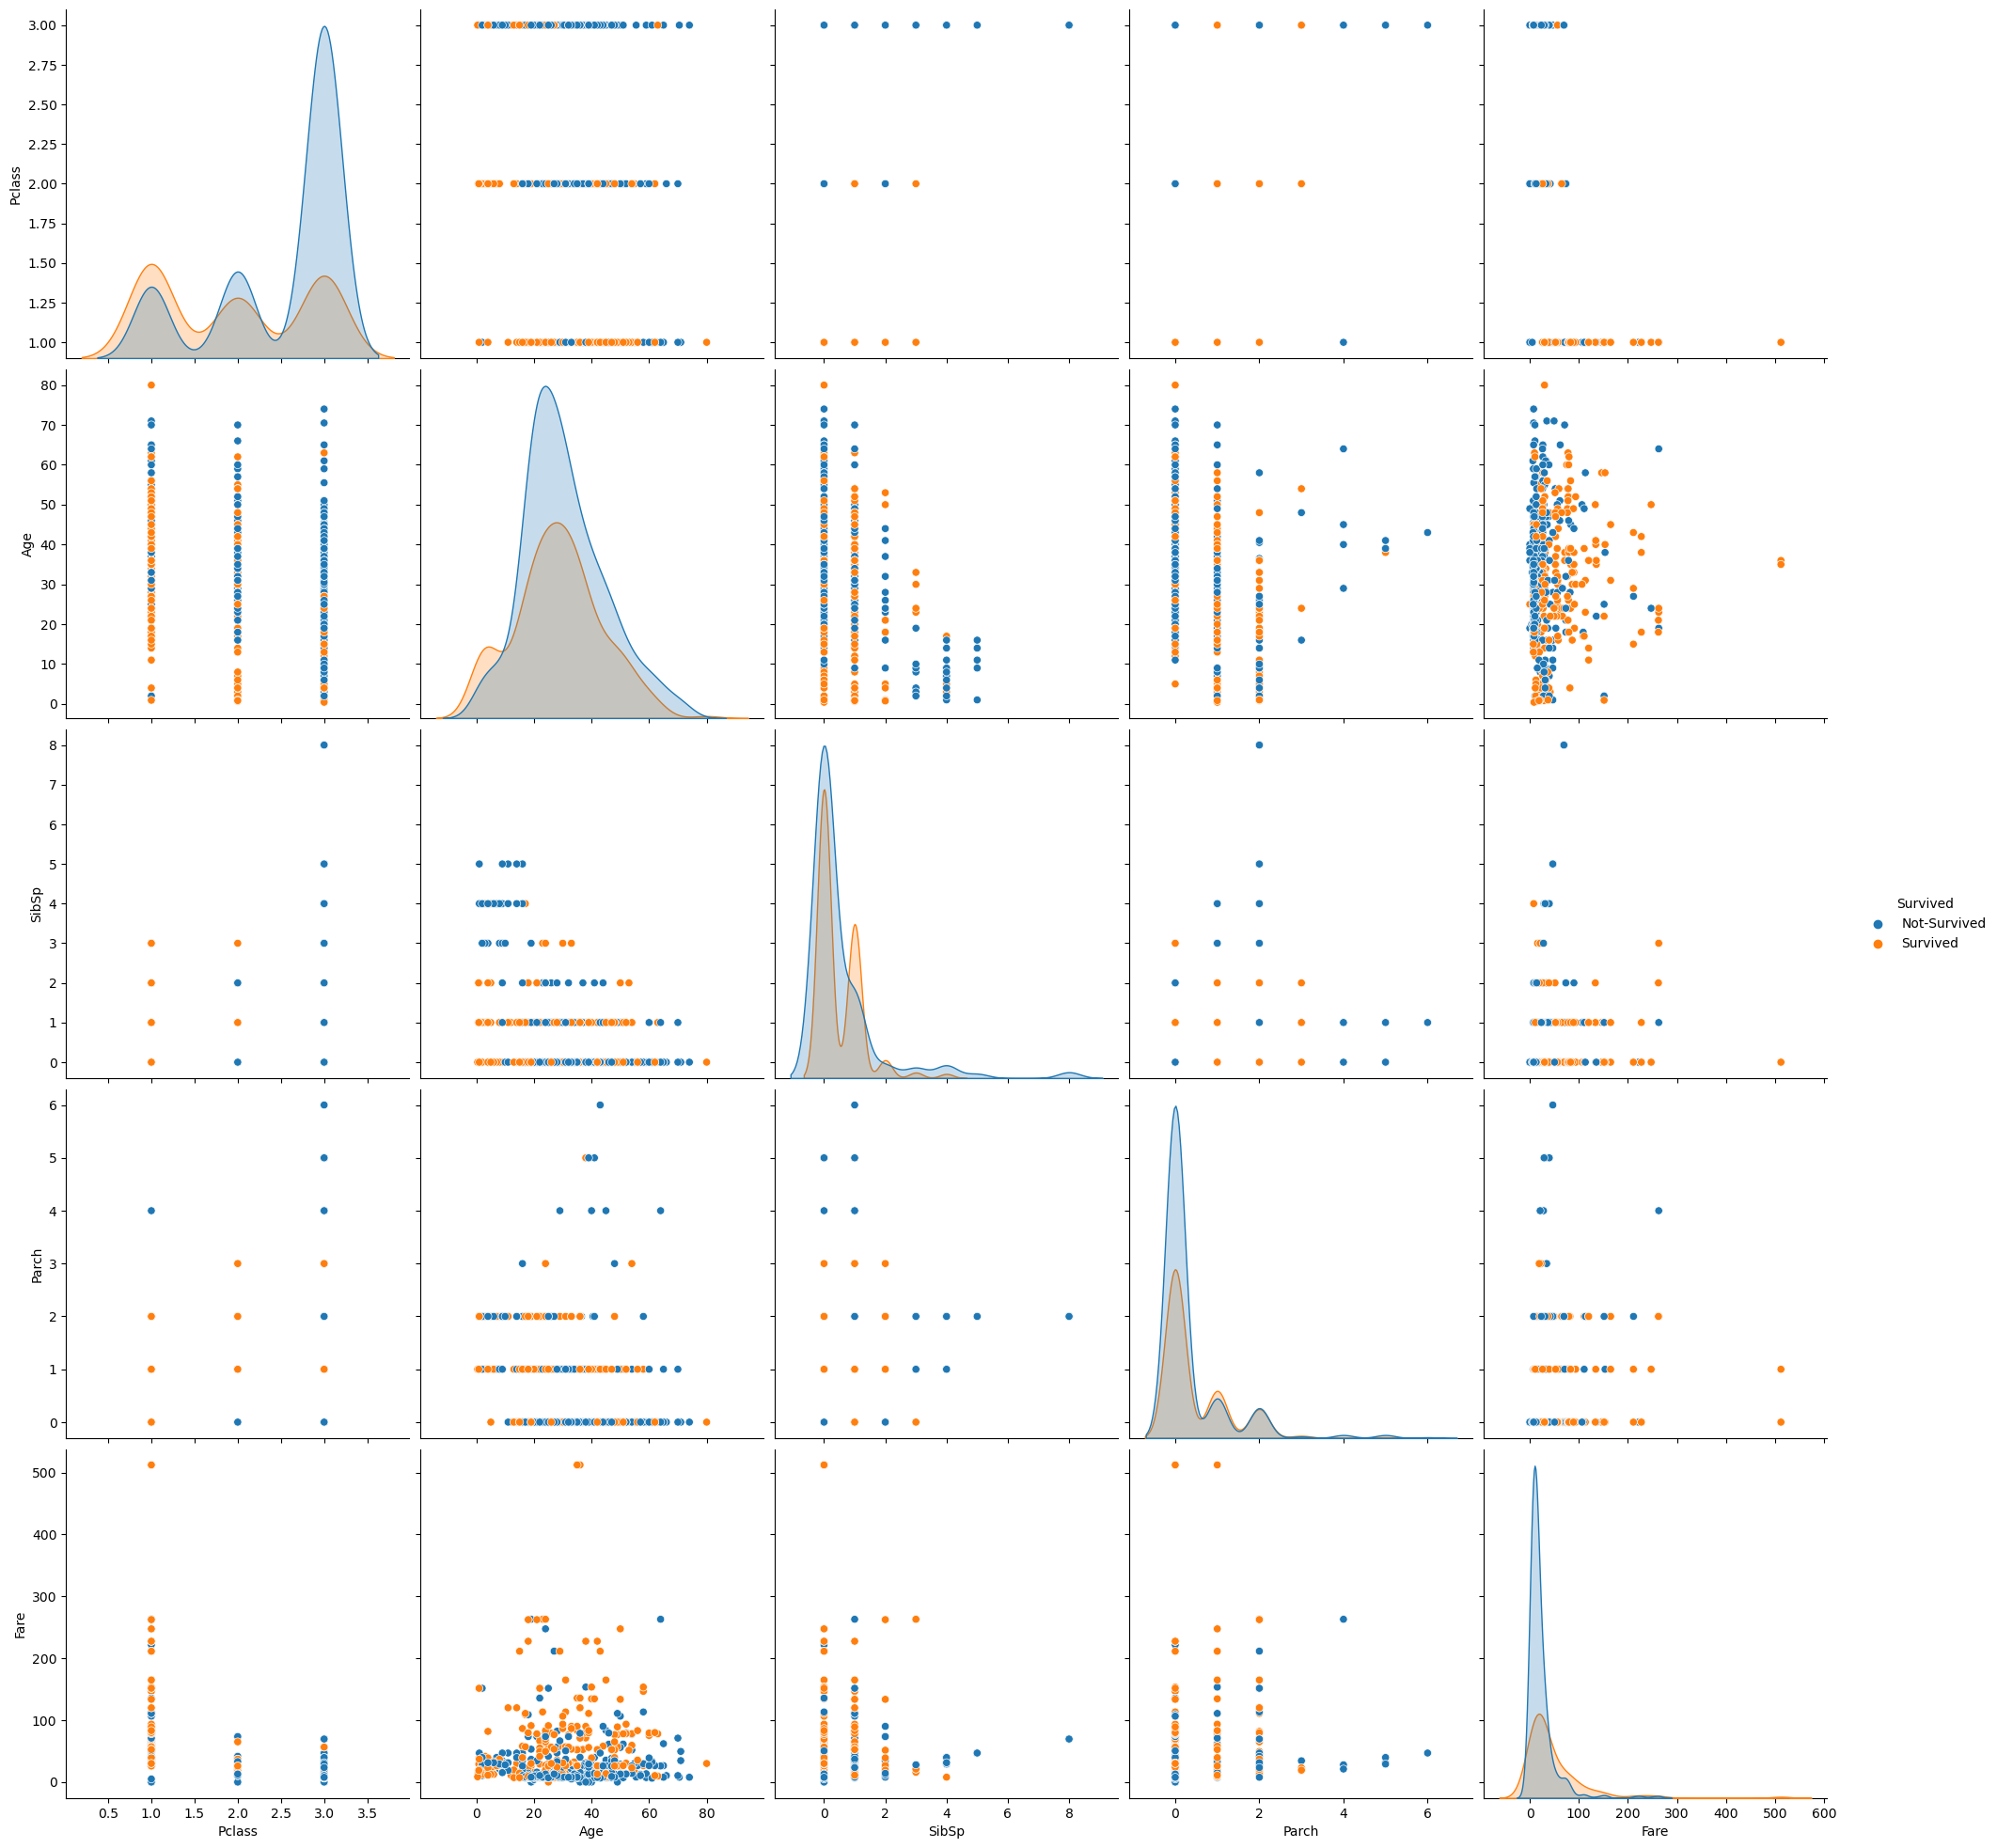

In [246]:
g=sns.pairplot(df1, hue=target, size=4)
plt.show()

In [247]:
counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: Number of duplicates dropped ---> 111


In [248]:
nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

          Total Null Values  Percentage
Survived                  0         0.0
Pclass                    0         0.0
Sex                       0         0.0
SibSp                     0         0.0
Parch                     0         0.0
Fare                      0         0.0
Embarked                  2         0.3
Age                     104        13.3


In [249]:
ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

#Target Variable
MAP={}
for i,e in enumerate(df1[target].unique()):
    MAP[e]=i
df1[target]=df1[target].map(MAP)
print('Mapping Target variable --->',MAP)

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1m\nOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

Mapping Target variable ---> {0: 0, 1: 1}

One-Hot Encoding on features:
Sex

Dummy Encoding on features:
Pclass
SibSp
Parch


(780, 17)

In [250]:
for x in [i for i in ecc if i in cf]:
    a = df1[x]
    b=[]; c=[]

    for i,e in enumerate(a):
        if e!=e:
            b.append(i)
        else:
            c.append(i)

    RF = RandomForestClassifier()
    RF.fit(df3.loc[c],a[c])
    d = RF.predict(df3.loc[b])

    df3[x] = a
    f=0
    for i,e in enumerate(df3[x]):
        if e!=e:
            df3.loc[i,x] = d[f]
            f+=1
    df3 = pd.concat([df3.drop([x], axis=1), pd.DataFrame(pd.get_dummies(df3[x], drop_first=True, prefix=str(x)))],axis=1)   
df3

,Survived,Sex,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,0,1,7.2500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,71.2833,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,53.1000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0,0,29.1250,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
776,1,0,30.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
777,0,0,23.4500,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
778,1,1,30.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [251]:
for x in [i for i in ecc if i not in cf]:
    a = df1[x]
    b=[]; c=[]

    for i,e in enumerate(a):
        if e!=e:
            b.append(i)
        else:
            c.append(i)

    LR = LinearRegression()
    LR.fit(df3.loc[c],a[c])
    d = LR.predict(df3.loc[b])

    df3[x] = a
    f=0
    for i,e in enumerate(df3[x]):
        if e!=e:
            df3.loc[i,x] = d[f]
            f+=1

df3

,Survived,Sex,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S,Age
0,0,1,7.2500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,22.000000
1,1,0,71.2833,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,38.000000
2,1,0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26.000000
3,1,0,53.1000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,35.000000
4,0,1,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0,0,29.1250,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,39.000000
776,1,0,30.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19.000000
777,0,0,23.4500,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,17.423426
778,1,1,30.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26.000000


In [252]:
df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.20)
        Q3 = df4[i].quantile(0.80)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

,Survived,Sex,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S,Age
0,0,1,7.2500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,22.0
1,1,0,71.2833,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,38.0
2,1,0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26.0
3,1,0,53.1000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,35.0
4,0,1,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35.0



Inference: Before removal of outliers, The dataset had 780 samples.
Inference: After removal of outliers, The dataset now has 727 samples.


In [253]:
df5 = df4.copy()

print('Original class distribution:')
print(df5[target].value_counts())

xf = df5.columns
X = df5.drop([target],axis=1)
Y = df5[target]

smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

df5 = pd.DataFrame(X, columns=xf)
df5[target] = Y

print('\nClass distribution after applying SMOTE Technique:',)
print(Y.value_counts())

Original class distribution:
0    444
1    283
Name: Survived, dtype: int64

Class distribution after applying SMOTE Technique:
0    444
1    444
Name: Survived, dtype: int64


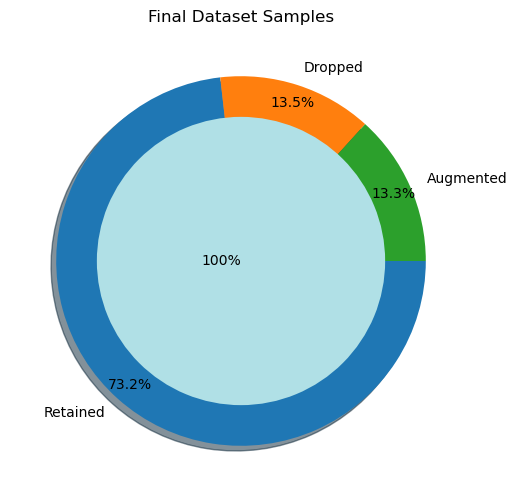


Inference:The final dataset after cleanup has 888 samples & 20 columns.


In [254]:
df = df5.copy()
plt.title('Final Dataset Samples')
plt.pie([df.shape[0], original_df.shape[0]-df4.shape[0], df5.shape[0]-df4.shape[0]], radius = 1, shadow=True,
        labels=['Retained','Dropped','Augmented'], counterclock=False, autopct='%1.1f%%', pctdistance=0.9, explode=[0,0,0])
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78, shadow=True, colors=['powderblue'])
plt.show()

print('\n\033[1mInference:\033[0mThe final dataset after cleanup has {} samples & {} columns.'.format(df.shape[0], df.shape[1]))

In [255]:
df = df5.copy()

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (888, 19) (888,) 
Training set  --->  (710, 19) (710,) 
Testing set   --->  (178, 19)  (178,)


In [256]:
std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,Sex,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S,Age
count,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,710.000000,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02
mean,-1.401070e-16,2.333032e-16,-1.501147e-17,-8.756689e-18,1.000764e-17,0.000000,4.003058e-17,2.001529e-17,-1.501147e-17,2.001529e-17,3.502675e-17,5.003822e-17,-2.001529e-17,-2.501911e-17,-5.003822e-18,1.751338e-17,6.129682e-17,1.426089e-16,-2.076586e-16
std,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00
min,-1.119807e+00,-1.129528e+00,-5.328283e-01,-1.008487e+00,-5.502293e-01,-0.182972,-1.067521e-01,-1.365700e-01,-8.421519e-02,-5.314940e-02,-3.663131e-01,-2.840241e-01,-8.421519e-02,-6.514047e-02,-7.527099e-02,-3.755579e-02,-2.692723e-01,-1.553532e+00,-2.161763e+00
25%,-1.119807e+00,-7.725496e-01,-5.328283e-01,-1.008487e+00,-5.502293e-01,-0.182972,-1.067521e-01,-1.365700e-01,-8.421519e-02,-5.314940e-02,-3.663131e-01,-2.840241e-01,-8.421519e-02,-6.514047e-02,-7.527099e-02,-3.755579e-02,-2.692723e-01,-1.553532e+00,-5.928776e-01
50%,8.930108e-01,-4.258290e-01,-5.328283e-01,9.915847e-01,-5.502293e-01,-0.182972,-1.067521e-01,-1.365700e-01,-8.421519e-02,-5.314940e-02,-3.663131e-01,-2.840241e-01,-8.421519e-02,-6.514047e-02,-7.527099e-02,-3.755579e-02,-2.692723e-01,6.436945e-01,-5.924307e-02
75%,8.930108e-01,2.295119e-01,-5.328283e-01,9.915847e-01,-5.502293e-01,-0.182972,-1.067521e-01,-1.365700e-01,-8.421519e-02,-5.314940e-02,-3.663131e-01,-2.840241e-01,-8.421519e-02,-6.514047e-02,-7.527099e-02,-3.755579e-02,-2.692723e-01,6.436945e-01,5.506250e-01
max,8.930108e-01,3.589908e+00,1.876777e+00,9.915847e-01,1.817424e+00,5.465306,9.367497e+00,7.322253e+00,1.187434e+01,1.881489e+01,2.729905e+00,3.520828e+00,1.187434e+01,1.535144e+01,1.328533e+01,2.662705e+01,3.713713e+00,6.436945e-01,3.218798e+00



                                Standardardization on Testing set                                


,Sex,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S,Age
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,1.780000e+02,1.780000e+02,178.000000,178.000000,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,178.000000,178.000000,178.000000
mean,-0.011627,-0.081975,-0.004881,-0.008451,0.061636,-0.119509,0.052926,0.072947,-8.421519e-02,-5.314940e-02,0.155521,-0.091644,-8.421519e-02,-6.514047e-02,-0.000211,-3.755579e-02,0.066373,-0.010536,0.173773
std,1.004074,0.924167,0.999514,1.002857,1.039411,0.597023,1.223004,1.235895,3.618403e-16,2.087540e-17,1.162322,0.835999,3.618403e-16,1.391694e-17,1.001419,2.087540e-17,1.109562,1.007560,1.193414
min,-1.119807,-1.129528,-0.532828,-1.008487,-0.550229,-0.182972,-0.106752,-0.136570,-8.421519e-02,-5.314940e-02,-0.366313,-0.284024,-8.421519e-02,-6.514047e-02,-0.075271,-3.755579e-02,-0.269272,-1.553532,-2.142705
25%,-1.119807,-0.772550,-0.532828,-1.008487,-0.550229,-0.182972,-0.106752,-0.136570,-8.421519e-02,-5.314940e-02,-0.366313,-0.284024,-8.421519e-02,-6.514047e-02,-0.075271,-3.755579e-02,-0.269272,-1.553532,-0.516644
50%,0.893011,-0.487539,-0.532828,-0.008451,-0.550229,-0.182972,-0.106752,-0.136570,-8.421519e-02,-5.314940e-02,-0.366313,-0.284024,-8.421519e-02,-6.514047e-02,-0.075271,-3.755579e-02,-0.269272,0.643695,0.084576
75%,0.893011,0.162025,-0.532828,0.991585,1.817424,-0.182972,-0.106752,-0.136570,-8.421519e-02,-5.314940e-02,-0.366313,-0.284024,-8.421519e-02,-6.514047e-02,-0.075271,-3.755579e-02,-0.269272,0.643695,1.069933
max,0.893011,2.924550,1.876777,0.991585,1.817424,5.465306,9.367497,7.322253,-8.421519e-02,-5.314940e-02,2.729905,3.520828,-8.421519e-02,-6.514047e-02,13.285330,-3.755579e-02,3.713713,0.643695,3.218798


In [257]:
Evaluation_Results = pd.DataFrame(np.zeros((2,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Decision Tree Classifier (DT)','K Nearest Neighbours (KNN)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
K Nearest Neighbours (KNN),0.0,0.0,0.0,0.0,0.0


In [258]:
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob[:,1], multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 83.7%
F1 Score = 83.7%

 Confusiton Matrix:
 [[79 15]
 [14 70]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84        94
           1       0.82      0.83      0.83        84

    accuracy                           0.84       178
   macro avg       0.84      0.84      0.84       178
weighted avg       0.84      0.84      0.84       178



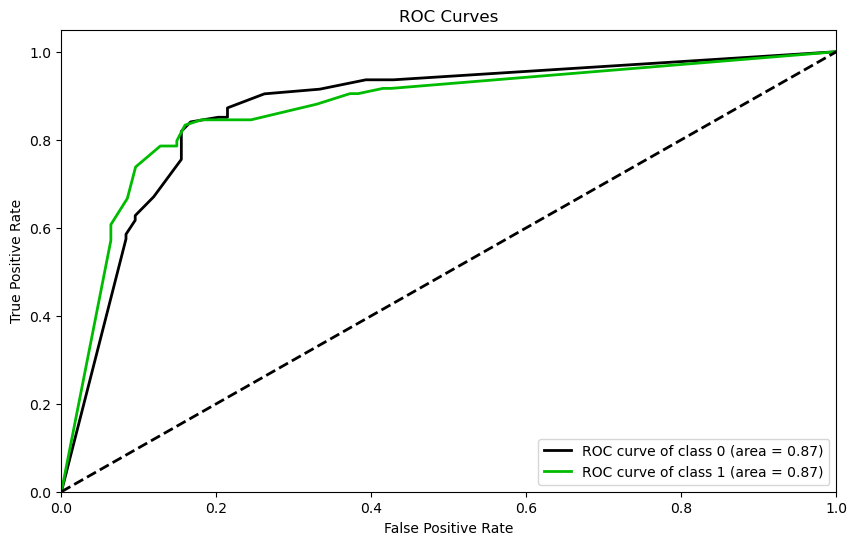


Interpreting the output of Decision Tree:



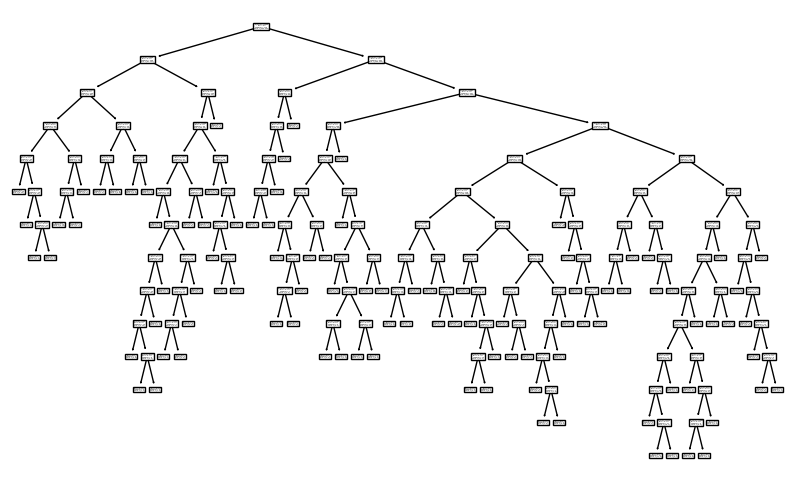

In [259]:
DT_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(DT_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

DT = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = DT.predict(Test_X_std)
pred_prob = DT.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,0)

print('\n\033[1mInterpreting the output of Decision Tree:\n\033[0m')
tree.plot_tree(DT)
plt.show()

<<<----------------------------------- Evaluating K Nearest Neighbours (KNN) ----------------------------------->>>

Accuracy = 79.2%
F1 Score = 79.2%

 Confusiton Matrix:
 [[78 16]
 [21 63]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81        94
           1       0.80      0.75      0.77        84

    accuracy                           0.79       178
   macro avg       0.79      0.79      0.79       178
weighted avg       0.79      0.79      0.79       178



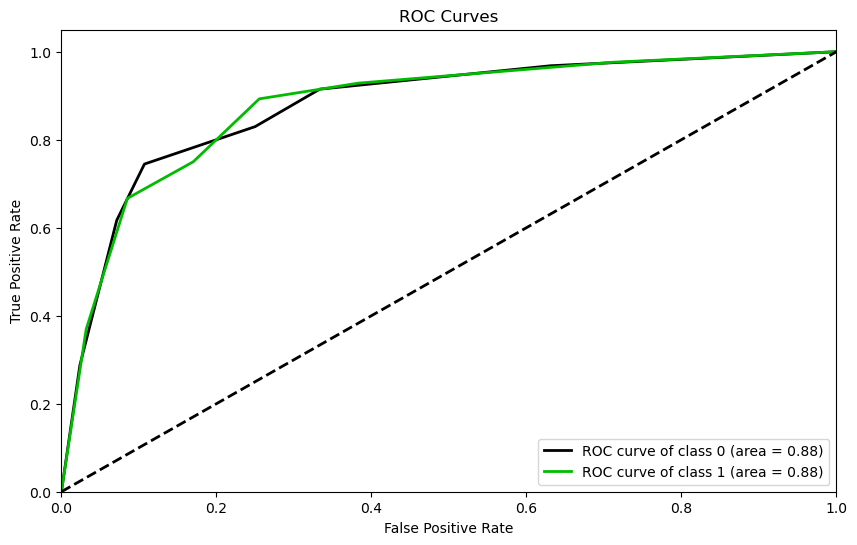

In [260]:
KNN_model = KNeighborsClassifier()

knn_param = {"n_neighbors": [i for i in range(1,30,5)],
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "leaf_size": [1, 10, 30],
             "p": [1,2]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(KNN_model, knn_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

KNN = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = KNN.predict(Test_X_std)
pred_prob = KNN.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,1)

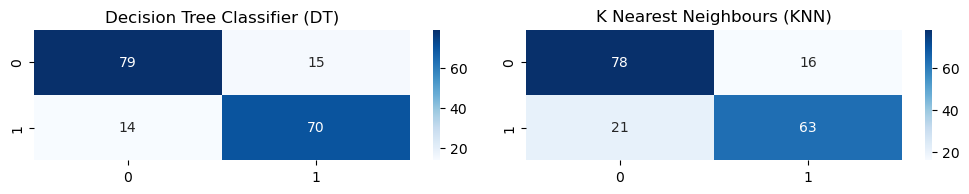

In [261]:
def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')

def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3.5*math.ceil(len(all_models)*len(labels)/14)])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/3),3,i+1)
        pred = all_models[i].predict(Test_X_std)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, cmap='Blues', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([DT,KNN])

                                                   ML Algorithms Comparison                                                   


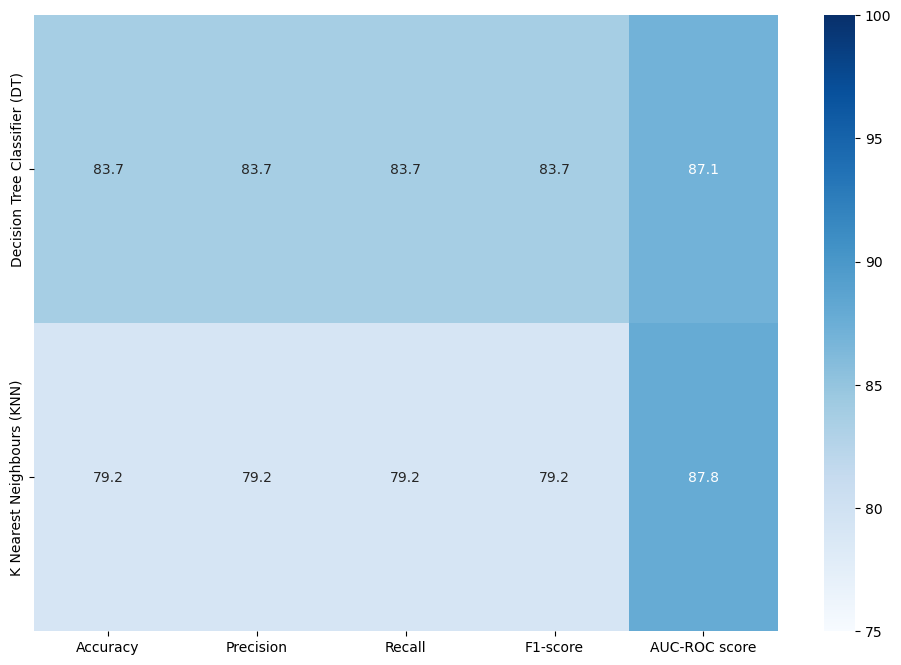

In [262]:
print('\033[1mML Algorithms Comparison'.center(130))
plt.figure(figsize=[12,8])
sns.heatmap(Evaluation_Results, annot=True, vmin=75, vmax=100, cmap='Blues', fmt='.1f')
plt.show()